In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install requests_cache
!pip install pandas_ta

     |████████████████████████████████| 44 kB 1.3 MB/s 
     |████████████████████████████████| 138 kB 10.2 MB/s 
     |████████████████████████████████| 127 kB 53.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 115 kB 5.7 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=7e6b3c76b7c059fec397324dbba2e44232235e4223286f32804b53ddb8458d10
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
import tensorflow
from pandas_datareader.data import DataReader
import requests_cache
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
import pandas_ta as pta

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_adj_close(ticker, start_date, end_date):
      # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
    try:
      s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
      s = s.loc[:,['Close', 'Open', 'Volume']]#s.loc[:,['Adj Close', 'Open', 'Volume']]
    except:
      print(ticker)
      s = pd.DataFrame(columns = ['Close', 'Open', 'Volume'])
    return s

In [ ]:
def read_clean(file_name):
  data = pd.read_csv(f'/content/drive/MyDrive/BT4222/{file_name}.csv', index_col = 0).loc[:,['Date', 'Text']]
  data = data.iloc[::-1]
  data = data.dropna()
  data['Text'] = data['Text'].astype(str)
  data = data.reset_index(drop = True)
  data['Date'] = data['Date'].apply(lambda x: x[:10])
  return data

In [ ]:
df_aapl = read_clean('Apple_sentiment')
df_aapl.head(3).append(df_aapl.tail(3))

,Date,Text
0,2016-04-27,"New York, April 27, 2016 -- Moody's Investors ..."
1,2017-09-25,Shutterstock/Christopher BoswellBrands are dea...
2,2017-09-25,YouTube/MKBHDTwo new iPhones went on sale this...
46480,2021-11-10,German chipmaker and Apple-supplier Infineon i...
46481,2021-11-10,Apple will be forced to allow app developers t...
46482,2021-11-10,Apple announced Wednesday it's launching a bus...


In [ ]:
df_fb = read_clean('Facebook_sentiment')
df_fb.head(3).append(df_fb.tail(3))

,Date,Text
0,2016-12-16,FacebookFacebook's internet-beaming Aquila was...
1,2016-12-20,The artificially intelligent virtual assistant...
2,2016-12-20,"There are really two Facebooks: One, the soci..."
26163,2021-11-04,"LISBON, Portugal — Facebook is wrong to shut d..."
26164,2021-11-05,"Meta, formerly known as Facebook, is discussin..."
26165,2021-11-04,As Mark Zuckerberg pursues a future in the met...


In [ ]:
df_pg = read_clean('P&G_sentiment')
df_pg.head(3).append(df_pg.tail(3))

,Date,Text
0,2016-12-21,Robots are going to take a seat at the confere...
1,2017-04-04,"In the United States, women are paid about 20%..."
2,2017-06-22,The American workplace has been under scrutiny...
4831,2021-10-29,"InvestorPlace - Stock Market News, Stock Advic..."
4832,2021-11-02,"InvestorPlace - Stock Market News, Stock Advic..."
4833,2021-11-04,"InvestorPlace - Stock Market News, Stock Advic..."


In [ ]:
nltk.download('vader_lexicon')
def get_sentiment(df):
  vader = SentimentIntensityAnalyzer()
  scores = df['Text'].apply(vader.polarity_scores).tolist()
  df_score = df.join(pd.DataFrame(scores))
  df_score = df_score.groupby('Date').mean()
  return df_score

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df_appl_sent, df_fb_sent, df_pg_sent = get_sentiment(df_aapl), get_sentiment(df_fb), get_sentiment(df_pg)

In [ ]:
start_date = '2010-01-01'
df_price_aapl = get_adj_close('AAPL', start_date, df_appl_sent.index[-1])
df_price_aapl.columns = ['close', 'open', 'volume']
df_price_fb = get_adj_close('FB', start_date, df_fb_sent.index[-1])
df_price_fb.columns = ['close', 'open', 'volume']
df_price_pg = get_adj_close('PG', start_date, df_pg_sent.index[-1])
df_price_pg.columns = ['close', 'open', 'volume']
df_price_ir = get_adj_close('^TNX', start_date, '2021-11-12')
df_price_ir.columns = ['close', 'open', 'volume']

In [ ]:
def process_price(df, df_ir):
  df['movement'] = np.where(df['close'] > df['close'].shift(1), 1, 0)
  df['movement'] = df['movement'].shift(-1)
  #Interest Rate
  df['ir'] = df_ir['open']
  #SMA
  df['SMA20'] = df['close'].rolling(window = 20).mean()
  df['SMA50'] = df['close'].rolling(window = 50).mean()
  df['SMA100'] = df['close'].rolling(window = 100).mean()
  #EMA
  df['EMA10'] = df['close'].ewm(span = 10, adjust = False).mean()
  df['EMA20'] = df['close'].ewm(span = 20, adjust = False).mean()
  df['EMA40'] = df['close'].ewm(span = 40, adjust = False).mean()
  #MACD
  exp1 = df['close'].ewm(span = 12, adjust = False).mean()
  exp2 = df['close'].ewm(span = 26, adjust = False).mean()
  df['MACD'] = exp1-exp2
  df['MACD'] = df['MACD']
  df['signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()
  #RSI 
  df['RSI'] = pta.rsi(df['close'], length = 14)
  return df

In [ ]:
df_appl_combine = df_appl_sent.join(process_price(df_price_aapl, df_price_ir))
df_fb_combine = df_fb_sent.join(process_price(df_price_fb, df_price_ir))
df_pg_combine = df_pg_sent.join(process_price(df_price_pg, df_price_ir))

In [ ]:
df_appl_combine.head(3).append(df_appl_combine.tail(3))

,neg,neu,pos,compound,close,open,volume,movement,ir,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,signal,RSI,volume shift
Date,,,,,,,,,,,,,,,,,,,
2006-12-13,0.041500,0.845500,0.113000,0.488400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-14,0.017000,0.954500,0.028500,0.134750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-15,0.085000,0.869000,0.047000,-0.202300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-09,0.023444,0.917833,0.058722,0.307561,150.809998,150.199997,56787900.0,0.0,1.464,148.769501,147.5412,146.0764,150.232387,149.021076,147.790724,1.437542,1.268370,57.884203,56787900.0
2021-11-10,0.046200,0.906533,0.047200,0.127720,147.919998,150.020004,65187100.0,0.0,1.473,149.120001,147.4630,146.2326,149.811952,148.916212,147.797030,1.167482,1.248193,48.459639,65187100.0
2021-11-11,0.000000,0.889500,0.110500,0.639600,147.869995,148.960007,41000000.0,NaN,1.560,149.325501,147.3702,146.3715,149.458869,148.816572,147.800590,0.938604,1.186275,48.313067,41000000.0


In [ ]:
from sklearn.preprocessing import StandardScaler
def get_train_test(df, exclude_col):
  train = df['2016-10-01':'2020-09-30']
  test = df['2020-10-01':'2021-09-30']
  train = train.dropna() #Weekends
  test = test.dropna() #Weekends
  train_temp = train[exclude_col]
  test_temp = test[exclude_col]
  train = train.drop(exclude_col, axis = 1)
  test = test.drop(exclude_col, axis = 1)
  scaler = StandardScaler()
  scaler.fit(train)
  train = pd.DataFrame(scaler.transform(train), columns = train.columns, index = train.index)
  test = pd.DataFrame(scaler.transform(test), columns = test.columns, index = test.index)
  train[exclude_col] = train_temp
  test[exclude_col] = test_temp
  return train, test

In [ ]:
aapl_train, aapl_test = get_train_test(df_appl_combine, ['movement'])
fb_train, fb_test = get_train_test(df_fb_combine, ['movement'])
pg_train, pg_test = get_train_test(df_pg_combine, ['movement'])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn import metrics
import xgboost as xgb
import keras
import keras.layers as layers
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import TextVectorization
import numpy as np
import nltk
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def logistic_regression_clf(train, test, X, y):
  clf = LogisticRegression().fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

def xgboost_clf(train, test, X, y):
  clf = xgb.XGBClassifier().fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

In [ ]:
def internal_process(df, df_price, X, y):
  def tokenize(txt):
    return ' '.join(word_tokenize(txt))
  df['Text'] = df['Text'].astype(str).apply(tokenize)
  df = df.set_index('Date')
  df = df.join(df_price)
  train, test = get_train_test(df, ['Text', 'movement'])
  train_features = {}
  test_features = {}
  for col in X:
    train_features[col] = tf.constant(train[col].to_list())
    test_features[col] = tf.constant(test[col].to_list())
  raw_train_ds = tf.data.Dataset.from_tensor_slices(
      (train_features, 
      tf.constant(train[y].to_numpy()))
  ).batch(32)
  raw_test_ds = tf.data.Dataset.from_tensor_slices(
      (test_features, 
      tf.constant(test[y].to_numpy()))
  ).batch(32)
  return raw_train_ds, raw_test_ds

def process_CNN_data(df, df_price, X, y):
  df, df_price = df.copy(), df_price.copy()
  raw_train_ds, raw_test_ds = internal_process(df, df_price, X, y)

  max_features = 20000
  embedding_dim = 128
  vectorize_layer = TextVectorization(
      standardize='lower_and_strip_punctuation',
      max_tokens=max_features,
      output_mode="int",
      output_sequence_length=500,
  )

  text_ds = raw_train_ds.map(lambda x, y: x['Text'])
  vectorize_layer.adapt(text_ds)

  def vectorize_text(text, label):
      text = text['Text']
      text = tf.expand_dims(text, -1)
      return vectorize_layer(text), label

  # Vectorize the data.
  train_ds = raw_train_ds.map(vectorize_text)
  test_ds = raw_test_ds.map(vectorize_text)

  # Do async prefetching / buffering of the data for best performance on GPU.
  train_ds = train_ds.cache().prefetch(buffer_size=10)
  test_ds = test_ds.cache().prefetch(buffer_size=10)
  return train_ds, test_ds, max_features, embedding_dim

def build_cnn_model(max_features, embedding_dim):
  model = keras.models.Sequential()
  model.add(layers.Embedding(max_features, embedding_dim))
  model.add(layers.Dropout(0.5))

  model.add(layers.Conv1D(128, 3, padding = "valid", activation = "relu"))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv1D(256, 5, padding = "valid", activation = "relu"))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dropout(0.4))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation="sigmoid", name="predictions"))

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC()])
  return model

def cnn_clf(df, df_price, X, y, epochs = 30):
  train_ds, test_ds, max_features, embedding_dim = process_CNN_data(df, df_price, X, y)
  model = build_cnn_model(max_features, embedding_dim)
  model.fit(train_ds, validation_data = test_ds, epochs=epochs)
  logits = np.array(model.predict(test_ds))
  predictions = np.where(logits >= 0.5, 1, 0)
  test_labels = np.array([k[1].numpy() for k in test_ds.unbatch()])

  accuracy = accuracy_score(test_labels, predictions)
  f1 = f1_score(test_labels, predictions)
  auc = roc_auc_score(test_labels, logits)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(test_labels, predictions), display_labels=[0,1]).plot(cmap = 'Blues')
  fpr, tpr, thresholds = roc_curve(test_labels, logits)
  RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr),estimator_name='CNN Model').plot()
  plt.show()
  return model, f1, auc

In [ ]:
data_lst = [[aapl_train, aapl_test]]#, [fb_train, fb_test], [pg_train, pg_test]]

SMA

In [ ]:
SMA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_sma_clfs = {}
lr_sma_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB SMA: {co}')
  xgb_sma, xgb_sma_f1, xgb_sma_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100'], 'movement')
  plt.show()
  print(f'LR SMA: {co}')
  lr_sma, lr_sma_f1, lr_sma_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100'], 'movement')
  plt.show()
  SMA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_sma_f1, xgb_sma_auc]
  SMA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_sma_f1, lr_sma_auc]
  xgb_sma_clfs[co] = xgb_sma
  lr_sma_clfs[co] = lr_sma

In [ ]:
SMA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.67374,0.488093,0.666667,0.49203
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


EMA

In [ ]:
EMA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_ema_clfs = {}
lr_ema_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB EMA: {co}')
  xgb_ema, xgb_ema_f1, xgb_ema_auc = xgboost_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40'], 'movement')
  plt.show()
  print(f'LR EMA: {co}')
  lr_ema, lr_ema_f1, lr_ema_auc = logistic_regression_clf(*data_lst[idx], ['EMA10', 'EMA20', 'EMA40'], 'movement')
  plt.show()
  EMA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_ema_f1, xgb_ema_auc]
  EMA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_ema_f1, lr_ema_auc]
  xgb_ema_clfs[co] = xgb_ema
  lr_ema_clfs[co] = lr_ema

In [ ]:
EMA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.0153846,0.48454,0.664865,0.464567
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + SMA

In [ ]:
TA_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TA_clfs = {}
lr_TA_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_ta, xgb_ta_f1, xgb_ta_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_ta, lr_ta_f1, lr_ta_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')
  plt.show()
  TA_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_ta_f1, xgb_ta_auc]
  TA_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_ta_f1, lr_ta_auc]
  xgb_TA_clfs[co] = xgb_ta
  lr_TA_clfs[co] = lr_ta

In [ ]:
TA_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.356436,0.519781,0.647727,0.493694
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + SMA + IR

XGB TA: AAPL
Accuracy: 0.528
F1 score: 0.5530303030303031
AUC score: 0.5103386466935534


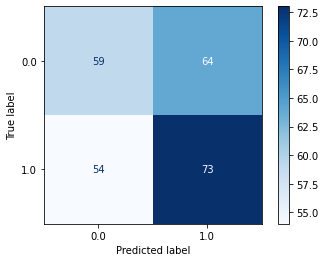

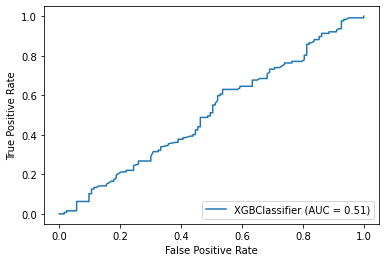

LR TA: AAPL
Accuracy: 0.512
F1 score: 0.6369047619047619
AUC score: 0.49113373023494017


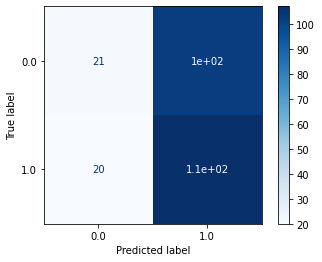

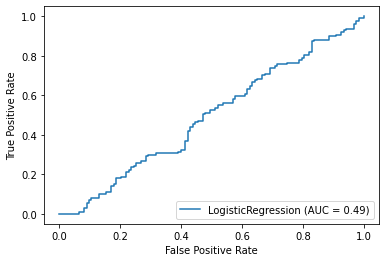

In [ ]:
TAIR_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAIR_clfs = {}
lr_TAIR_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_tair, xgb_tair_f1, xgb_tair_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_tair, lr_tair_f1, lr_tair_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume'], 'movement')
  plt.show()
  TAIR_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_tair_f1, xgb_tair_auc]
  TAIR_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_tair_f1, lr_tair_auc]
  xgb_TAIR_clfs[co] = xgb_tair
  lr_TAIR_clfs[co] = lr_tair

In [ ]:
TAIR_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.55303,0.510339,0.636905,0.491134
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


MACD + RSI + SMA + SENTIMENT

In [ ]:
TAIR_sent_df = pd.DataFrame(index = ['AAPL', 'FB', 'PG'], columns = ['F1_XGB', 'AUC_XGB', 'F1_LR', 'AUC_LR'])
xgb_TAIR_sent_clfs = {}
lr_TAIR_sent_clfs = {}
for idx, co in enumerate(['AAPL']):#, 'FB', 'PG']):
  print(f'XGB TA: {co}')
  xgb_tair_sent, xgb_tair_sent_f1, xgb_tair_sent_auc = xgboost_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume shift', 'neg', 'neu', 'pos', 'compound'], 'movement')
  plt.show()
  print(f'LR TA: {co}')
  lr_tair_sent, lr_tair_sent_f1, lr_tair_sent_auc = logistic_regression_clf(*data_lst[idx], ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI', 'ir', 'volume shift', 'neg', 'neu', 'pos', 'compound'], 'movement')
  plt.show()
  TAIR_sent_df.loc[co, ['F1_XGB', 'AUC_XGB']] = [xgb_tair_sent_f1, xgb_tair_sent_auc]
  TAIR_sent_df.loc[co, ['F1_LR', 'AUC_LR']] = [lr_tair_sent_f1, lr_tair_sent_auc]
  xgb_TAIR_sent_clfs[co] = xgb_tair_sent
  lr_TAIR_sent_clfs[co] = lr_tair_sent

In [ ]:
TAIR_sent_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
AAPL,0.621795,0.519845,0.651163,0.489853
FB,NaN,NaN,NaN,NaN
PG,NaN,NaN,NaN,NaN


In [ ]:
result_df = SMA_df.append(EMA_df).append(TA_df).append(TAIR_df)
result_df = result_df.dropna()

In [ ]:
result_df['Indicators'] = ['SMA', 'EMA', 'SMA+MACD+RSI', 'SMA+MACD+RSI+IR+VOL']
result_df = result_df.set_index('Indicators')
result_df

,F1_XGB,AUC_XGB,F1_LR,AUC_LR
Indicators,,,,
SMA,0.67374,0.488093,0.666667,0.49203
EMA,0.0153846,0.48454,0.664865,0.464567
SMA+MACD+RSI,0.356436,0.519781,0.647727,0.493694
SMA+MACD+RSI+IR+VOL,0.55303,0.510339,0.636905,0.491134


XGB TUNING

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from time import time
from tqdm import tqdm

In [ ]:
def evaluate_auc(xgb_clf, train, test, X):
  clf = xgb_clf.fit(train.loc[:,X], train['movement'])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test['movement']
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  return auc

In [ ]:
def hyperopt(param_space, num_eval, classifier, train, test, X):  
    start = time()
    def objective_function(params):
        clf = classifier(**params)
        score = evaluate_auc(clf,  train, test, X)
        return {'loss': -score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    print(loss)
    return trials, best_param_values

In [ ]:
num_eval = 500

XGB_param_hyperopt = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 550, 20)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 25, 1)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'booster': hp.choice('booster', ['dart','gbtree']), #gblinear
    'gamma': hp.uniform('gamma', 0, 20),
    'min_child_weight': hp.uniform('min_child_weight', 1, 5),
    'subsample': hp.uniform('subsample', 0.1, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.9),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.9),
    'reg_lambda': hp.uniform('reg_lambda', 1, 5),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 0.1),
    'scale_pos_weight':hp.uniform('scale_pos_weight', 1, 10),
    'use_label_encoder':False,
    'random_state': 1
}

In [ ]:
XGB_hyperopt = hyperopt(XGB_param_hyperopt,  num_eval, xgb.XGBClassifier, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'])

100%|██████████| 500/500 [04:32<00:00,  1.83it/s, best loss: -0.5777799116573843]
[-0.4978874591895525, -0.4972793035016964, -0.5022085653927405, -0.5, -0.527270981371231, -0.49382241853914594, -0.492894180910313, -0.5, -0.47756225593752005, -0.5234299980795083, -0.47442545291594646, -0.5233979898854108, -0.5023686063632289, -0.5112028679341912, -0.5040650406504065, -0.5351770053133602, -0.53850585749952, -0.5072338518660777, -0.5122591383394149, -0.5350169643428717, -0.5078740157480315, -0.5006401638819539, -0.5084821714358876, -0.5032008194097689, -0.5107227450227259, -0.4921259842519685, -0.4950387299148582, -0.4872607387491198, -0.5202291786697395, -0.51440368734396, -0.49519877088534664, -0.5194609820113949, -0.4758978298444402, -0.51481979386723, -0.4928301645221177, -0.5063056142372447, -0.521509506433647, -0.5014723769284937, -0.470872543371103, -0.5199731131169579, -0.48402791114525323, -0.4899814352474233, -0.5142436463734716, -0.5, -0.5115869662633634, -0.4844760258626208, -

In [ ]:
import json
def trials_data(xgb_hyperopt):
    trials = xgb_hyperopt[0].trials
    bayesTrialsData = pd.DataFrame()
    for idx, trial in enumerate(trials):
        loss = trial["result"]["loss"]
        values = list(map(lambda x: x[0], trial["misc"]['vals'].values()))
        label = list(trial["misc"]['vals'].keys())
        index = ['loss']
        index = index + label
        data = [loss]
        data = data + values
        df = pd.DataFrame(data, columns = [idx], index = index).T
        bayesTrialsData = bayesTrialsData.append(df)
    bayesTrialsData = bayesTrialsData.sort_values(by='loss')
    return bayesTrialsData

def xgboost_clf_optim(xgb_clf, train, test, X, y):
  clf = xgb_clf.fit(train.loc[:,X], train[y])
  y_pred = clf.predict(test.loc[:,X])
  y_pred_proba = clf.predict_proba(test.loc[:,X])[:,1]
  y_test = test[y]
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_proba)
  print(f'Accuracy: {accuracy}')
  print(f'F1 score: {f1}')
  print(f'AUC score: {auc}')
  plot_confusion_matrix(clf, test.loc[:,X], test[y], cmap = 'Blues')
  plot_roc_curve(clf, test.loc[:,X], test[y])
  return clf, f1, auc

In [ ]:
XGB_hyperopt_trails = trials_data(XGB_hyperopt)
#XGB_hyperopt_trails

Accuracy: 0.508
F1 score: 0.6737400530503979
AUC score: 0.5777799116573843


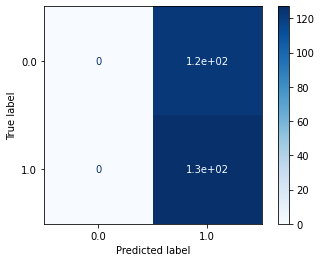

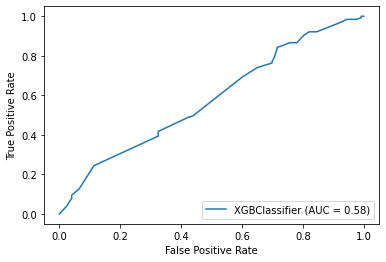

In [ ]:
xg_chosen = XGB_hyperopt[1]
xgb_optimised = xgb.XGBClassifier(random_state = 1, use_label_encoder = False,
                                    booster=['dart','gbtree'][xg_chosen['booster']], 
                                    colsample_bylevel = xg_chosen['colsample_bylevel'],
                                    colsample_bynode = xg_chosen['colsample_bynode'], 
                                    colsample_bytree=xg_chosen['colsample_bytree'],
                                    gamma = xg_chosen['gamma'], 
                                    learning_rate=xg_chosen['learning_rate'],
                                    max_depth=int(xg_chosen['max_depth']),
                                    min_child_weight = xg_chosen['min_child_weight'],
                                    n_estimators = int(xg_chosen['n_estimators']),
                                    reg_alpha = xg_chosen['reg_alpha'], 
                                    reg_lambda = xg_chosen['reg_lambda'],
                                    scale_pos_weight = xg_chosen['scale_pos_weight'],
                                    subsample = xg_chosen['subsample'])
xgb_best, xgb_f1_best, xgb_auc_best = xgboost_clf_optim(xgb_optimised, aapl_train, aapl_test, ['SMA20', 'SMA50', 'SMA100', 'MACD', 'signal', 'RSI'], 'movement')

In [ ]:
model, cnn_f1, cnn_auc = cnn_clf(df_aapl, df_price_aapl, ['Text', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI'], 'movement', 50)

In [ ]:
model, cnn_f1, cnn_auc = cnn_clf(df_fb, df_price_fb, ['Text', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI'], 'movement', 50)

In [ ]:
model, cnn_f1, cnn_auc = cnn_clf(df_pg, df_price_pg, ['Text', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'signal', 'RSI'], 'movement', 50)